In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, Input, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

BASE_DIR = '/kaggle/input/utkface-new/UTKFace'
IMG_SIZE = (128, 128)
BATCH_SIZE = 128
EPOCHS = 100

2025-08-07 06:51:54.639622: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754549514.843007      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754549514.908895      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def load_data():
    images, genders = [], []
    for file in tqdm(os.listdir(BASE_DIR)):
        temp = file.split('_')
        if len(temp) >= 2 and temp[1].isdigit():
            genders.append(int(temp[1]))
            img_path = os.path.join(BASE_DIR, file)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE, color_mode='grayscale')
            img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img)
    
    images = np.array(images)
    genders = np.array(genders)
    return images, genders

In [3]:
def get_data_augmentation():
    return tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
    ])

In [4]:
def build_model():
    inputs = Input(shape=(128, 128, 1))
    x = get_data_augmentation()(inputs)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = Dropout(0.5)(x)
    
    gender_output = Dense(1, activation='sigmoid', name='gender')(x)
    
    model = Model(inputs=inputs, outputs=gender_output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    model.summary()
    return model

In [5]:
def compute_gender_class_weights(genders):
    classes = np.unique(genders)
    class_weights = compute_class_weight('balanced', classes=classes, y=genders)
    return {0: class_weights[0], 1: class_weights[1]}

In [6]:
def compute_sample_weights(genders, class_weights):
    sample_weights = np.zeros(len(genders))
    for i, gender in enumerate(genders):
        sample_weights[i] = class_weights[gender]
    return sample_weights

100%|██████████| 23708/23708 [02:18<00:00, 171.36it/s]
I0000 00:00:1754549667.741687      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754549667.742418      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gender (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,129 (16.36 MB)

 Trainable params: 4,287,681 (16.36 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100


I0000 00:00:1754549677.965353      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5515 - loss: 3.1751
Epoch 1: val_accuracy improved from -inf to 0.65015, saving model to /kaggle/working/gendertask2.weights.h5
112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 160ms/step - accuracy: 0.5516 - loss: 3.1591 - val_accuracy: 0.6501 - val_loss: 1.2690
Epoch 2/100
111/112 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.6164 - loss: 0.6962
Epoch 2: val_accuracy did not improve from 0.65015
112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 0.6167 - loss: 0.6960 - val_accuracy: 0.5875 - val_loss: 4.3950
Epoch 3/100
111/112 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.6333 - loss: 0.6847
Epoch 3: val_accuracy did not improve from 0.65015
112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 0.6334 - loss: 0.6845 - val_accuracy: 0.5989 - val_loss: 2.7925
Epoch 4/100
111/112 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6684 - loss: 0.6576
Epoch 4: val_accuracy improved from 0.65015 to 0.69528, saving model to /kaggle/workin

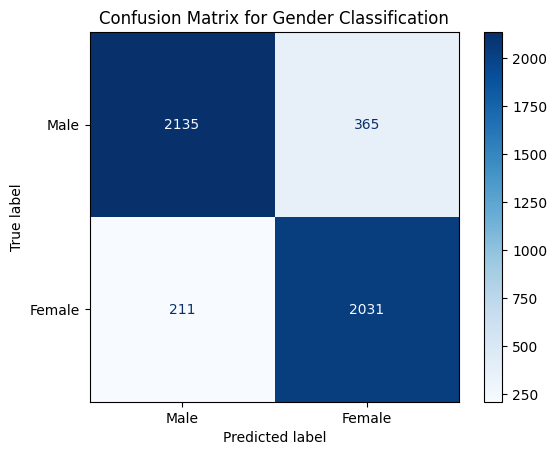

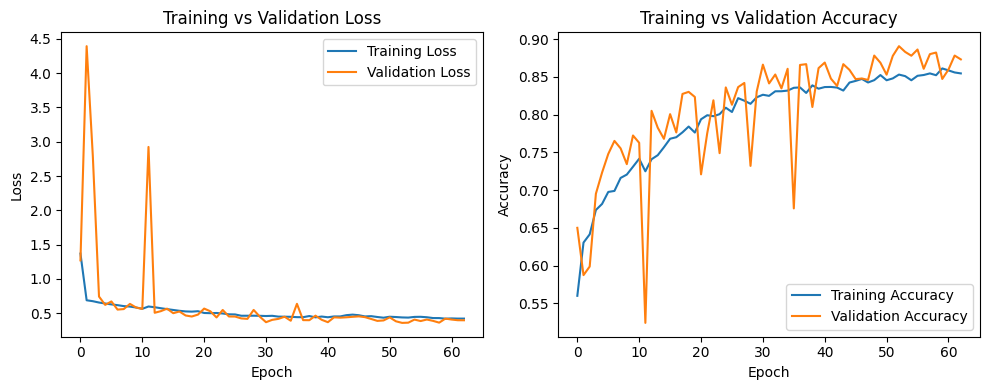

In [7]:
images, genders = load_data()
X_temp, X_test, y_temp_gender, y_test_gender = train_test_split(
    images, genders, test_size=0.2, random_state=42, shuffle=True
)
X_train, X_val, y_train_gender, y_val_gender = train_test_split(
    X_temp, y_temp_gender, test_size=0.25, random_state=42, shuffle=True  
)

class_weights = compute_gender_class_weights(y_train_gender)
sample_weights = compute_sample_weights(y_train_gender, class_weights)
model = build_model()
checkpoint = ModelCheckpoint(
    '/kaggle/working/gendertask2.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

history = model.fit(
    X_train,
    y_train_gender,
    validation_data=(X_val, y_val_gender),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint,early_stopping],
    sample_weight=sample_weights,
    verbose=1
)
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print(f"\nFinal Training Accuracy: {train_acc:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")
print("Loading best weights.")
model.load_weights('/kaggle/working/gendertask2.weights.h5')

test_loss, test_accuracy = model.evaluate(X_test, y_test_gender, verbose=1)
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  
y_test_classes = y_test_gender 
precision = precision_score(y_test_classes, y_pred_classes, average='binary')
recall = recall_score(y_test_classes, y_pred_classes, average='binary')
f1 = f1_score(y_test_classes, y_pred_classes, average='binary')

print(f"Test Gender Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

cm = confusion_matrix(y_test_classes, y_pred_classes)
class_labels = ["Male", "Female"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Gender Classification')
plt.show()
model.save('/kaggle/working/gendertask2.h5')

plt.figure(figsize=(10, 4))   
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()